In [1]:
import numpy as np
import pandas as pd
import time
from datetime import datetime
import json
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/var/folders/zr/0mklm_6s5zg8kfjw3xy0w3bh0000gn/T/ipykernel_68616/3700585894.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import sys
sys.path.append('/Users/tylermartin/Documents/programming/london_weather/london-weather')

from datetime import timedelta
from matplotlib import cm
from matplotlib.colors import Normalize

from make_plots import apply_mdates

In [3]:
TOP_DIR='/Users/tylermartin/Documents/programming/london_weather'
DRIVE_DIR='/Users/tylermartin/Google Drive/My Drive/projects/london_weather'

In [4]:
def f_to_c(f):
    return round((f-32)*5/9,2)

In [9]:
files =list(Path(TOP_DIR).glob('data/*.parquet'))
files.sort()

In [ ]:
df=pd.concat([pd.read_parquet(f) for f in tqdm(files)])

df['temp_c']=df.temp.apply(f_to_c)
df['date']=df.ts.dt.floor('D')
day=df.groupby('date').temp_c.max().to_frame().reset_index()

  0%|          | 0/3733 [00:00<?, ?it/s]

In [ ]:
freq='year'
color='red'

_ = plt.plot(day.date, day.temp_c, c=color, alpha=.8, label='daily mean')
fig, ax = plt.gcf(), plt.gca()
ax=apply_mdates(ax,freq)

_ = ax.legend(loc=1)
_ = ax.grid()

name='temp'
place='london'
title_text = f'Mean {name} over for London'
_ = ax.set_title(title_text, size=15)
fig.set_size_inches(20,5)

In [38]:
day['temp_roll']=day.temp_c.rolling(window=5).mean()
day['year']=day.date.dt.year

In [39]:
for year in range(2015,2023):
    offset=year-2000
    m=day.year==year
    day.loc[m,'month']=day.date-timedelta(days=365*offset+5)

In [43]:
day.sample(5)

,date,temp_c,temp_roll,year,month
2460,2021-09-26,22.03,22.094,2021,2000-09-26
902,2017-06-21,32.03,30.434,2017,2000-06-20
1673,2019-08-01,24.20,22.598,2019,2000-07-31
439,2016-03-15,8.41,10.202,2016,2000-03-14
932,2017-07-21,21.22,23.036,2017,2000-07-20


In [44]:
min_date=pd.to_datetime('2000 05 01')
max_date=pd.to_datetime('2000 09 01')
m=(day.month>min_date)&(day.month<max_date)
day=day[m].copy()

In [45]:
day

,date,temp_c,temp_roll,year,month
123,2015-05-04,18.58,15.938,2015,2000-05-02
124,2015-05-05,15.69,16.134,2015,2000-05-03
125,2015-05-06,13.86,16.332,2015,2000-05-04
126,2015-05-07,16.67,16.852,2015,2000-05-05
127,2015-05-08,16.89,16.338,2015,2000-05-06
...,...,...,...,...,...
2729,2022-06-22,26.04,23.520,2022,2000-06-22
2730,2022-06-23,25.21,23.368,2022,2000-06-23
2731,2022-06-24,22.73,24.238,2022,2000-06-24
2732,2022-06-25,19.43,23.660,2022,2000-06-25


In [46]:
def get_style(year):
    c='black'
    alpha=.2
    ls='-'
    lw=1
    if year==2020:
        c='green'
        alpha=.8
        lw=3
    if year==2021:
        c='purple'
        alpha=.8
        lw=3
    return c,alpha,ls,lw

In [65]:
day

,date,temp_c,temp_roll,year,month
123,2015-05-04,18.58,15.938,2015,2000-05-02
124,2015-05-05,15.69,16.134,2015,2000-05-03
125,2015-05-06,13.86,16.332,2015,2000-05-04
126,2015-05-07,16.67,16.852,2015,2000-05-05
127,2015-05-08,16.89,16.338,2015,2000-05-06
...,...,...,...,...,...
2729,2022-06-22,26.04,23.520,2022,2000-06-22
2730,2022-06-23,25.21,23.368,2022,2000-06-23
2731,2022-06-24,22.73,24.238,2022,2000-06-24
2732,2022-06-25,19.43,23.660,2022,2000-06-25


In [66]:
mean=day.groupby('month').temp_roll.mean().to_frame().reset_index()

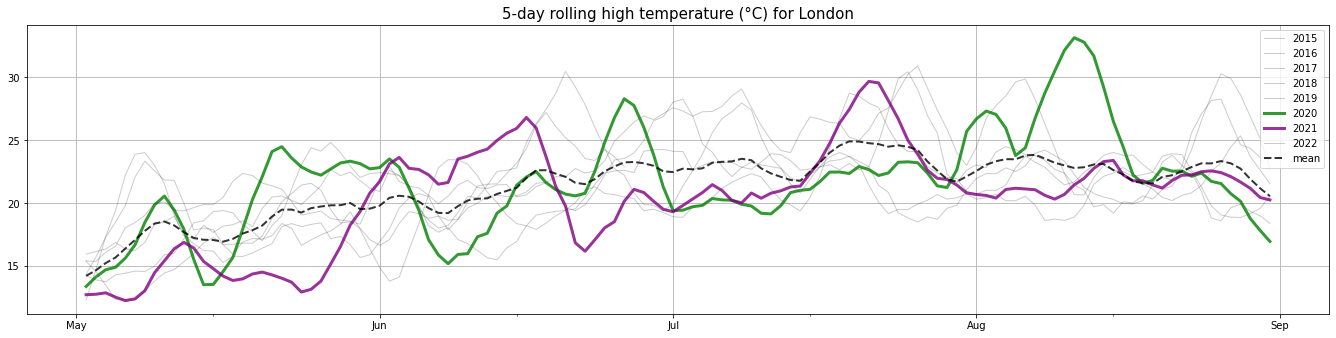

In [70]:
freq='month_no_year'

plt.figure(facecolor='white')

for year in range(2015,2023):
    c,alpha,ls,lw=get_style(year)
    to_plot=day[day.year==year]
    _ = plt.plot(to_plot.month,to_plot.temp_roll,c=c,alpha=alpha,ls=ls,label=year,lw=lw)

_ = plt.plot(mean.month,mean.temp_roll,c='black',alpha=.8,ls='--',label='mean',lw=2)

fig, ax = plt.gcf(), plt.gca()
ax=apply_mdates(ax,freq)

_ = ax.legend(loc=1)
_ = ax.grid()

title_text = f'5-day rolling high temperature (°C) for London'
_ = ax.set_title(title_text, size=15)
_=plt.tight_layout()
fig.set_size_inches(20,5)
path=f'{TOP_DIR}/plots/london.png'
plt.savefig(path,dpi=300)

drive_path=f'{DRIVE_DIR}/london.png'
plt.savefig(drive_path,dpi=300)

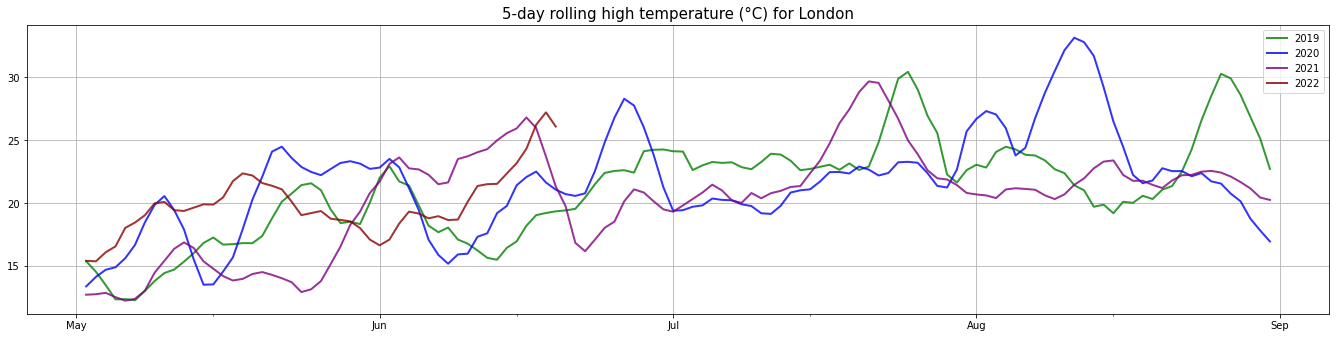

In [17]:
freq='month_no_year'
#colors=['goldenrod','red','darkred','black']
colors=['green','blue','purple','darkred']
lss=['-','--','-.','-']
lss=['-','-','-','-']
plt.figure(facecolor='white')

for year,c,ls in zip(range(2019,2023),colors,lss):
    to_plot=day[day.year==year]
    #_ = plt.plot(to_plot.month, to_plot.temp_c, c=c, alpha=.8, label=year)
    _ = plt.plot(to_plot.month,to_plot.temp_roll,c=c,alpha=.8,ls=ls,label=year,lw=2)

fig, ax = plt.gcf(), plt.gca()
ax=apply_mdates(ax,freq)

_ = ax.legend(loc=1)
_ = ax.grid()

title_text = f'5-day rolling high temperature (°C) for London'
_ = ax.set_title(title_text, size=15)
_=plt.tight_layout()
fig.set_size_inches(20,5)
path=f'{TOP_DIR}/plots/london.png'
plt.savefig(path,dpi=300)

In [188]:
name='Blues'
cmap=plt.get_cmap(name)

In [197]:
cmap = cm.Blues
cmap = cm.plasma
cmap = cm.rainbow
norm = Normalize(vmin=0, vmax=4)
#cmap(norm(1))

colors=[cmap(norm(x)) for x in range(1,5)]

In [198]:
colors

[(0.0019607843137254832, 0.7092813076058534, 0.9232891061054894, 1.0),
 (0.503921568627451, 0.9999810273487268, 0.7049255469061472, 1.0),
 (1.0, 0.7005430375932911, 0.37841105004231035, 1.0),
 (1.0, 1.2246467991473532e-16, 6.123233995736766e-17, 1.0)]